In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import os
import random
import matplotlib.gridspec as gridspec
from collections import defaultdict

In [2]:
from tensorflow.keras import backend as K
import tensorflow as tf

from tensorflow.keras.layers import Input, Dropout, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

In [5]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

# Load word count table for all NOS articles

In [6]:
all_data = pd.read_csv('Data/NOS_articles_with_word_counts.csv') 

In [7]:
all_data = all_data.set_index('Unnamed: 0')

In [8]:
all_data = all_data.loc[:, ~ all_data.columns.str.contains('Unnamed')]

In [10]:
all_data.shape

(42924, 13151)

## Define key words per topic

In [3]:
topics = {
'Branden & brandweer':[ 'bosbranden','brand','bosbrandgebied','brandweer','vuur'],

'Politiek & verkiezingen':['verkiezingen','politiek','lijsttrekker','kamerverkiezingen','verkiezingen','oppositieleider','oppositie','parlementsverkiezingen','partijcongressen','referendumopkomst','referendum','verkiezing','stemmen','stembureau','democratie','stemmers','congreslid'],

'Politie':['politie','agent','agenten','politieagent','politiemissie','politiebureau','politiebond','politiegeweld', 'korpschef','politieactie'],

'Inlichtingendienst':['aftappen','aivd','inlichtingendienst','inlichtingendiensten','afluistermicrofoons','afluisteren','afluistermicrofoon','afluisterprogramma','nsa','telefoontaps','telefoontap','nsa','spionage'],

'Diplomatie':['diplomaat','diplomatie','ambassade','ambassadeur','sancties','onderhandelingen','onderhandeling','vredesonderhandelingen','vredesonderhandeling'],

'Discriminatie':['discriminatie','discrimineren','racisme','racist','ongelijkheid','neonazi','vrouwendiscriminatie','hakenkruizen','seksistisch','racistische','racistisch','seksist','antisemitisme'],

'Demonstraties':['demonstraties','demonstratie','protest','protesten','demonstreren','demonstrant','demonstranten','spandoek','spandoeken','protesteren'],

'Defensie':['defensie','militairen','militair','militaire','soldaten','leger', 'luchtmacht','dienstplicht','patrouilleschepen','marine','landmacht'],

'Duurzame energie':['duurzaam','duurzame','energietransitie','duurzaamheid','windenergie','zonnepanelen','zonnepaneel','klimaatneutraal', 'windmolen','windmolens','zonne-energie','waterstof'], 

'Klimaatverandering':['klimaatverandering','co2','co2-uitstoot','opwarming','klimaatcrisis','klimaat','klimaatneutraal','klimaattop','klimaatbeleid','klimaatmars','ijskappen','ijskap','klimaatbescherming','klimaatactivisten','klimaatactivist'],

'Rechtbank & rechter':['rechtbank','rechter','rechters','rechterstaat','veroordeling','straf','levenslang','doodstraf','gehoorzitting','strafhof', 'gevangenissen','gevangenis','taakstraf','gevangenisstraf','advocaat','advocaten','strafdossier'],

'Criminaliteit & drugs':['criminaliteit','drugs','drugshandel','drugsactie','drugssmokkel','drugspanden','drugsvangst','drugshandelaren','drugssmokkel','drugsnetwerk', 'cocainevangst','kartel','drugsgeld','witwassen','cocaine','heroine','drugspand','kartelbaas','xtc'], 

'Criminaliteit & geweld':['criminaliteit','slachtoffer','neergestoken','verdachte','geweld','steekpartij','neergestoken','crimineel','schietpartij','doodgeschoten','mishandeld','neersteken','liquidatie','doodslaan','doodsteken','daders','dader','schietincident','munitie','wapens'], 

'Diefstal':['inbreker','inbrekers','inbraak','diefstallen','diefstal','autodieven','dieven','plofkrakers','plofkraak','stelen','gestolen','woninginbraken','woninginbraak','zakkenrollers','zakkenroller'],

'Corruptie & fraude': ['corruptie','smeergeld','omkoping','omkopen','corruptiezaken','corruptiezaak','fraude','fraudezaak','fraudezaken','frauderen','corruptieschandaal','corrupte'],

'Veehouderijen & vlees':['vlees','vee','veehouderij','veehouders','veehouder','melkveehouders','vleesconsumptie','pluimvee','veeteelt','vleesleveranciers', 'varkenshouderij','varkenshouderijen', 'melkveehouderijen','melkveehouder','slagerijen','vleesverbruik','veestapel','slachterij','vleesleverancier'],

'Landbouw & boeren':['landbouw','boeren','boer','landbouwsector','akkerbouw','akker','oogst','akkers','oogsten','tulpentelers','tulpenteler', 'fruitteler','fruittelers','fruitoogst'],

'Werk':['werk','werkgever','werknemers','baan','banen','werkgelegenheid','werkloos','werkloosheid', 'salaris', 'arbeidsmarkt','arbeiders','arbeider','salarisverlaging'],

'Woningmarkt':['woningmarkt','woningcorporaties','huizenprijzen','woningtekort','woningen','koopwoning','huurprijs','huisbaas','huurwoning','woningnood','nieuwbouwprojecten','koopwoningen','huisbaas','huizenkopers','nieuwbouwwijk','nieuwbouwwoningen','huurhuizen','nieuwbouw','woonwijk','wonen','villa', 'huurprijzen','hypotheekrente','hypotheek','hypotheekverstrekkers','hypotheekverstrekker','hypotheken','hypotheekrenteaftrek','hypotheekregels'],

'Pensioen':['pensioen','pensioenstelsel','pensioenakkoord','pensioenleeftijd','pensioenpremies','pensioenstelsels', 'pensioenen','pensioenoverleg','pensioenfondsen','pensioenpremie','pensioenhervorming','pensioenfonds'],

'Oorlog & conflicten':['oorlog','conflict','conflicten','doden','dood','gewonden','bom','bommen','bombardement','luchtaanvallen','taliban','isis','qaida', 'konvooi','terreurgroep','gevechtshelikopter','raketaanval','wapens','kindsoldaten','separatisten'],

'Stikstof':['stikstof','stikstofcrisis','stikstofuitstoot','stikstofregels','stikstofvonnis', 'stikstofcijfers', 'stikstofplannen','stikstofwet', 'stikstofmaatregel','stikstofmaatregels', 'stikstofberekeningen', 'stikstofcijfer', 'stikstofdossier', 'stikstofneerslag','stikstofactivist','stikstofproblemen','stikstofmaatregelen'],

'Kernenergie':['kernenergie','kerncentrale','kerncentrales','nucleaire','nucleair','kernafval','atoombesluit','uraniummijnen','uranium','kernramp','jodiumpillen','stralingsrecord'],

'Belasting':['belasting','accijns','belastingen','belastingdienst','belastingtoeslag','tax','taks','winstbelasting','belastingparadijzen','belastingparadijs'],

'Vakbonden':['vakbonden','coa','vakbond','fnv'],

'Reizen & Openbaar vervoer':['vervoer','trein','ns','bus','reiziger','reizigers','treinstations','treinstation','spoorweg','prorail','buschauffeur'],

'Studielening':['studieschuld','studielening','leenstelsel','studiebeurs','stufi','leenstelselgeld'],

'Onderwijs':['leraar','school','scholen','studeren','universiteit','studenten','hoogleraar','universiteiten','onderwijsinspectie', 'student','studerende','opleiding','docent','docenten','lerares'],

'Vliegen':['vliegen','vliegtuig','klm','ryanair','luchthavens','luchthaven','boeing','vliegveld','vliegtickets','schiphol','airbus','easyjet'], 

'Vakantie & tourisme':['tourisme','touristen','tourist','vakantie','vakantiedagen','vakantiebestemming','vakantiebestemmingen','vakantiehuis','vakantiehuisjes','zomervakantie',
'vakantiehuisje','vakantiepark','vakantieparken'],

'Seksueel misbruik & seksualiteit':['misbruik','seksueel','verkrachten','verkrachting','aanranding','aanranden','verkrachter','seks','misbruikslachtoffer','misbruikslachtoffers'],

'Voetbal':['voetbal','voetballen','uefa','voetballer','voetbalster','feyenoord','psv','ajax'],

'Data & privacy & algoritmes':['privacywet','privacy','privacyschender','priveschandalen','privacyproblemen','datalek','datalekken', 'privacyrecht','data','algoritmes','algoritme'],

'Sport':['sport','sporten','wedstrijd','medaille','wereldkampioen','wielrenner','wielrennen','zwemmen','hockey','coach', 'kampioen','trainer','tennis','volleybal','honkbal','olympisch','olympische','tourwinnaar'],

'Zorg':['ziekenhuis','verpleger','verplegers','arts','artsen','ziekenhuizen','patiënten','patiënt','dokter','huisarts','zorginstelling','gezondheid', 'zorgverzekeraars','zorgverzekeraar','verpleger','verplegers','verpleging','woonzorgcentrum','ouderzorg','verpleeghuizen','verpleeghuis','gehandicaptenzorg'],

'Coronavirus':['coronavirus','corona','covid19','covid-19','besmetting','besmettingen','covid-patiënten','coronavaccin','coronamaatregelen','coronamaatregel', 'coronapatiënt','coronapatiënten','coronapakket','coronapatient','coronapatienten'],

'Asielzoekers & vluchtelingen':['asielzoekers','asielzoeker','asielzoekerscentra','asiel','asielzoekerscentrum','vluchtelingen','asielzoekersgroep','opvangkampen','asielprocedure',
'vluchteling','vluchtelingenstroom','migranten','migrantenkamp','vluchtelingenkamp','vluchtelingenbootjes','vluchtelingenboot'],

'Europese Unie':['europees','europese','europa','eu','eu-lidstaat','eu-lidstaten','eu-leiders','eu-leider'],

'Afval':['afval','vuilnis','zwerfafval','plastic','recycling','recycle','afvalberg','afvalstort','recyclebaar','luchtvervuiling','statiegeld', 'prullenbakken','prullenbak','afvalcontainer','recyclingbedrijf','afvalverwerker','vervuild','vervuilde'],

'Homoseksualiteit': ['homoseksualiteit','homoseksuelen','homoseksueel','gay','homo','homoacceptatie','homos','homorechten','lesbische','lesbisch'],

'Medicijnen':['medicijnen','farmaceut','geneesmiddelen','geneesmiddel','medicijn','geneesmiddelfabrikant','vaccin','vaccinatie', 'geneesmiddelfabrikanten','farmaceutische','farmaceutisch','pijnstiller','antibiotica'], 

'Gas':['gas','gaswinning','aardgas','gasboring','schaliegas','gasveld'],

'Natuur & dieren':['natuur','natuurgebied','dieren','dier','vogels','insecten','insect','boom','plantensoorten','milieu','schapen','veluwe','broedplek','oerwoud','weilanden','vijver', 'natuurreservaten','natuurreservaat','regenwoud','zoogdieren','staatsbosbeheer', 'weiland','zoogdieren','dierentuin','biodiversiteit','zoogdier','planten','plant','organisme','organismen'],

'Aanslagen & terrorisme':['aanslag','aanslagen','bom','terrorisme','terrorist','terreuraanslagen','terreuraanslag','verijdelt','zelfmoordaanslagen','zelfmoordaanslag','autobom','terrorismeverdachte','terreurgroep','terreur'],

'Banken':['bank','banken','bankencrisis','rente','rabobank','triodos','ing','internetbankieren','amro','bankieren','bankier','ecb'],

'Verkeer':['auto','verkeer','vrachtwagen','snelweg','snelwegen','maximumsnelheid','spoorwegovergangen','buschauffeur','taxi','automobilisten','automobilist','asfalt','automobiliste', 'bestuurder','vrachtwagens','verkeersongeluk','botsing'],

'Bedrijfsleven & economie':['bedrijfsleven','bedrijven','mkb','bedrijf','bedrijven','winst','omzet','aex','handelscontracten',
'aandelen','aandeelhouders','aandeelhouder','aandelenbeurs','miljardenverlies','failliet','faillissement'],


'Consumenten':['kopen','consumenten','producten','winkels','kleding','consumeren','consumentenbond','marketing','scheepvaartmuseum','aankoop','consument','winkel','winkelen', 'aankopen','shoppen'],

'Cultuur & musea': [ 'rijksmuseum','toneel','theater','musea','museum', 'cultuur','cultureel','kunstwerk','kunstenaar','kunstenaren','straatartiesten','theatermakers', 'disney','hollywood','film','bioscoop','cabaretier','filmindustrie','oscar','artiesten','artiest','acteur','cultuurprijs'],

'Olie & kolen & grijze energie':['olie','olieproductie','olieproducerende','olieproducent','kerosine','benzine','diesel','shell','olieplatforms','olieplatform','oliereus','bp','benzineprijs','benzineprijzen','kolencentrale','kolencentrales','kolencentralen','olieraffinaderijen','olieraffinaderij','kolengestookte','steenkool','fossiele','olieboringen', 'olieboring','steenkool','brandstofprijs','brandstofprijzen','olieprijs','olieprijzen'],

'Prostitutie & mensenhandel':['prostitutie','bordeel','bordelen','sekswerker','sekswerkers','prostituee','prostituees','prostitueerde','mensensmokkelnetwerk', 'mensenhandel','mensensmokkel','mensenhandelaar','mensenhandelaars','mensenhandelaren','mensensmokkelaar'],

'Zwangerschap & abortus ':['zwangerschap','zwanger','zwangeren','miskramen','verpleegkundigen','verpleegkundige','baby','bevalling','moeder','moeders','baarmoeder','abortus','abortuskliniek','abortusklinieken','abortusmanifestatie','sterilisatie','abortusreferendum','anticonceptie','abortusklinieken'],

'Festival & feesten':['festival','feestende','feesten','feest','festivals','festivalseizoen','pinkpop','lowlands','festivalbezoekers','festivalbezoeker',
'muziek','rockmuzikant','muzikant','muzikanten','carnaval'],

'Scheepvaart':['vrachtschip','schepen','schip','vrachtschepen','scheepvaart'],

'Islam':['islam','moskee','imams','imam','allah','koran','islamitisch','islamitische','moskeeen','moskeeën'],

'Christendom':['christendom','christus','jezus','kerk','priester','paus','kerkdienst','priesters','pastor','katholieke','vaticaan','kerkdiensten'],

'Wiet': ['wiet','wietteelt','coffeeshop','cannabis','wietplant','coffeeshops','wietroker','jointjes','wietbeleid','hennepkwekerijen','wietteler','wiettelers','wietproef','hennepkwekerij','hennep','wietplantage','wietplantages'],


'China':['china','xi','chinees','chinese','chinezen','ccp'],

'Natuurramp & extreem weer':['orkaan','overstroming','bosbranden','bosbrand','overstromingen','aardbeving','overstromingsgebied','droogte','vulkaanuitbarsting','vulkaan','hittegolf', 'wervelstorm','aardbevingen','tsunami','aardverschuiving','windstoten','noodweer','overstromingsgevaar','wateroverlast','stormschade','aardbevingen','natuurbrand','natuurbranden'],

'Mensenrechten': ['amnesty','mensenrechten','mensenrechtenorganisaties','mensenrechtenorganisatie','mensenrechtenactivist','mensenrechtenactivisten','kinderarbeid', 'dwangarbeid','meningsuiting','mensenrechtenschendingen','mensenrechtenadvocaat','mensenrechtenschenders','mensenrechtenschender'],

'Koningshuis':['koning','koningin','prinsessen','prinses','koningshuis','prins','koninginnedag','koningspaar'],

'Ruimtevaart':['ruimtecapsule','ruimtevaart','nasa','spacex','satelliet','satellieten','planeet','planeten','aardobservatiesatelliet', 'ruimtetelescoop','lancering','iss','astronaut','astronauten','ruimtevaart','zonnestelsel','sterrenstelsel'],


}

# Some special character removal
topics = {u: [ re.sub('[^A-Za-z0-9 ]+', '', t).lower() for t in v] for u,v in topics.items()}

# Classifier

### Input matrix

In [24]:
# Make input for training 
X = all_data.fillna(0)
# Normalize word counts
X= (X.iloc[0:].T / X.iloc[0:] .sum(axis=1)).T

### Labels

In [27]:
nr_to_label = { i:topic for i,(topic,words) in enumerate(topics.items())}

In [ ]:
y = []
for art_word,row in X.iterrows():
    if( 'txt' in art_word):
        words_in_article = row[row > 0.001 ].index.tolist()
        zeros = np.zeros(len(topics) )
        for i,(topic,words) in enumerate(topics.items()):
            
            overlap = set(words_in_article).intersection(words)
            if( len(overlap) > 1):
                zeros[i] = 1
    
        if( sum(zeros) >= 4):
            zeros = np.zeros(len(topics) )
        
        zeros = list(zeros)
        y.append( zeros)
    else:
        print(row.name)
        zeros = list(np.zeros(len(topics)))
        y.append(zeros)
        
y = np.array(y)

In [301]:
y = pd.DataFrame(y, index = X.index )
y = y.rename(columns  = nr_to_label)

In [303]:
# Remove articles without label
art_sel = y.sum(axis=1)
art_sel = art_sel[art_sel!=0].index

In [ ]:
X_sel = X.loc[art_sel]
y_sel = y.loc[art_sel]

In [305]:
len(art_sel)

29054

### Make classifier NN

In [35]:
# Define model
x_in = Input(shape=(X.shape[1],))

drop_1 = Dropout(0.2)(x_in)
D_1 =  Dense(200, activation='tanh')(drop_1)
drop_2 = Dropout(0.1)(D_1)
D_2 =  Dense(50, activation='tanh')(drop_2)
drop_3 = Dropout(0.1)(D_2)
D_3 =  Dense(y.shape[1], activation=None)(drop_3)

def custom_output(x):
    return tf.exp(x) / tf.reduce_sum(tf.exp(x), axis=1, keepdims=True)

max_layer = Lambda(custom_output,name='max')(D_3)

# Build model
model = Model(inputs=[x_in], outputs=max_layer)

### Training

In [317]:
losses = []

In [ ]:
optimizer = Adam(lr=1e-2)

# Classification performance
def loss_fn(y, y_pred):
    return CategoricalCrossentropy()(y, y_pred)

# Training steps
for i in range(10000):
    # Random training set
    mask = (np.random.randint(0,20,len(X_sel)) == 0)
    
    with tf.GradientTape() as tape:
        predictions = model([ X_sel.loc[mask] ], training=True)
        loss = loss_fn(y_sel.loc[mask], predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    losses.append(loss.numpy())
    
    print(sum(mask),loss.numpy() )
    


In [ ]:
ind = 0
plt.plot(range(len(losses[ind:])),losses[ind:])
plt.plot(range(len(losses[ind:])),pd.Series(losses[ind:]).rolling(window=25,center=True).mean() )

In [352]:
X_pred = pd.DataFrame(model.predict(X_sel), index = X_sel.index ).rename(columns = nr_to_label)

In [ ]:
X_pred.head()

# Verkiezingsprogrammas

In [7]:
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

In [368]:
used_words_for_training =  X_sel.columns.tolist()

In [8]:
partijen = [p.strip('.pdf') for p in os.listdir('Data/Verkiezingsprogrammas/')]

# Some error occured with this document, need to be fixed
partijen.remove('DENK')

In [ ]:

for partij in partijen:
    
    file = 'Results/{}_topics_over_doc.csv'.format(partij)
    if( not os.path.exists(file) ):
    
        path = 'Verkiezingsprogramma/{}.pdf'.format(partij)
        text_pdf = convert_pdf_to_txt(path)
        text_pdf_clean = re.sub('[^A-Za-z0-9 ]+', '', text_pdf).lower().split(' ')

        res = []
        blocksize= 100
        ii = np.arange(0,len(text_pdf_clean), int( blocksize / 3) )
        for k,i in enumerate(ii):
            print(k,len(ii))

            w = text_pdf_clean[ i : i + blocksize  ]

            w = [ el for el in w if len(el) > 1]
            ws = []
            for el in w:
                ws.extend( [ el_.lower() for el_ in el.split(' ') if len(el_) > 1] )
            ws = pd.Series(ws).value_counts()

            ws.name = 'verkiezingsprogramma'
            ws = ws.loc[ set(used_words_for_training).intersection(ws.index) ]
            diff_words = list(set(used_words_for_training).difference(ws.index))
            ws = ws.append(pd.Series( np.zeros(len(diff_words)),index = diff_words)) 
            
            # Normalize word counts
            ws = ws / ws.sum()        
 
            x = ws.reset_index().set_index('index').T
            x = x[used_words_for_training]

            probs = pd.DataFrame(model.predict(x), index = x.index ).rename(columns = nr_to_label )

            x = probs.iloc[0]
            x.name = i
            res.append(x)


        topics_over_doc = pd.DataFrame(res)
        topics_over_doc.to_csv(file)




# Make plots

In [9]:
topics_over_doc = pd.DataFrame([])
for partij in partijen:
    df = pd.read_csv( 'Results/{}_topics_over_doc.csv'.format(partij) ).rename( columns = {'Unnamed: 0':'step'})
    df['partij'] = partij
    topics_over_doc = pd.concat([topics_over_doc,df])

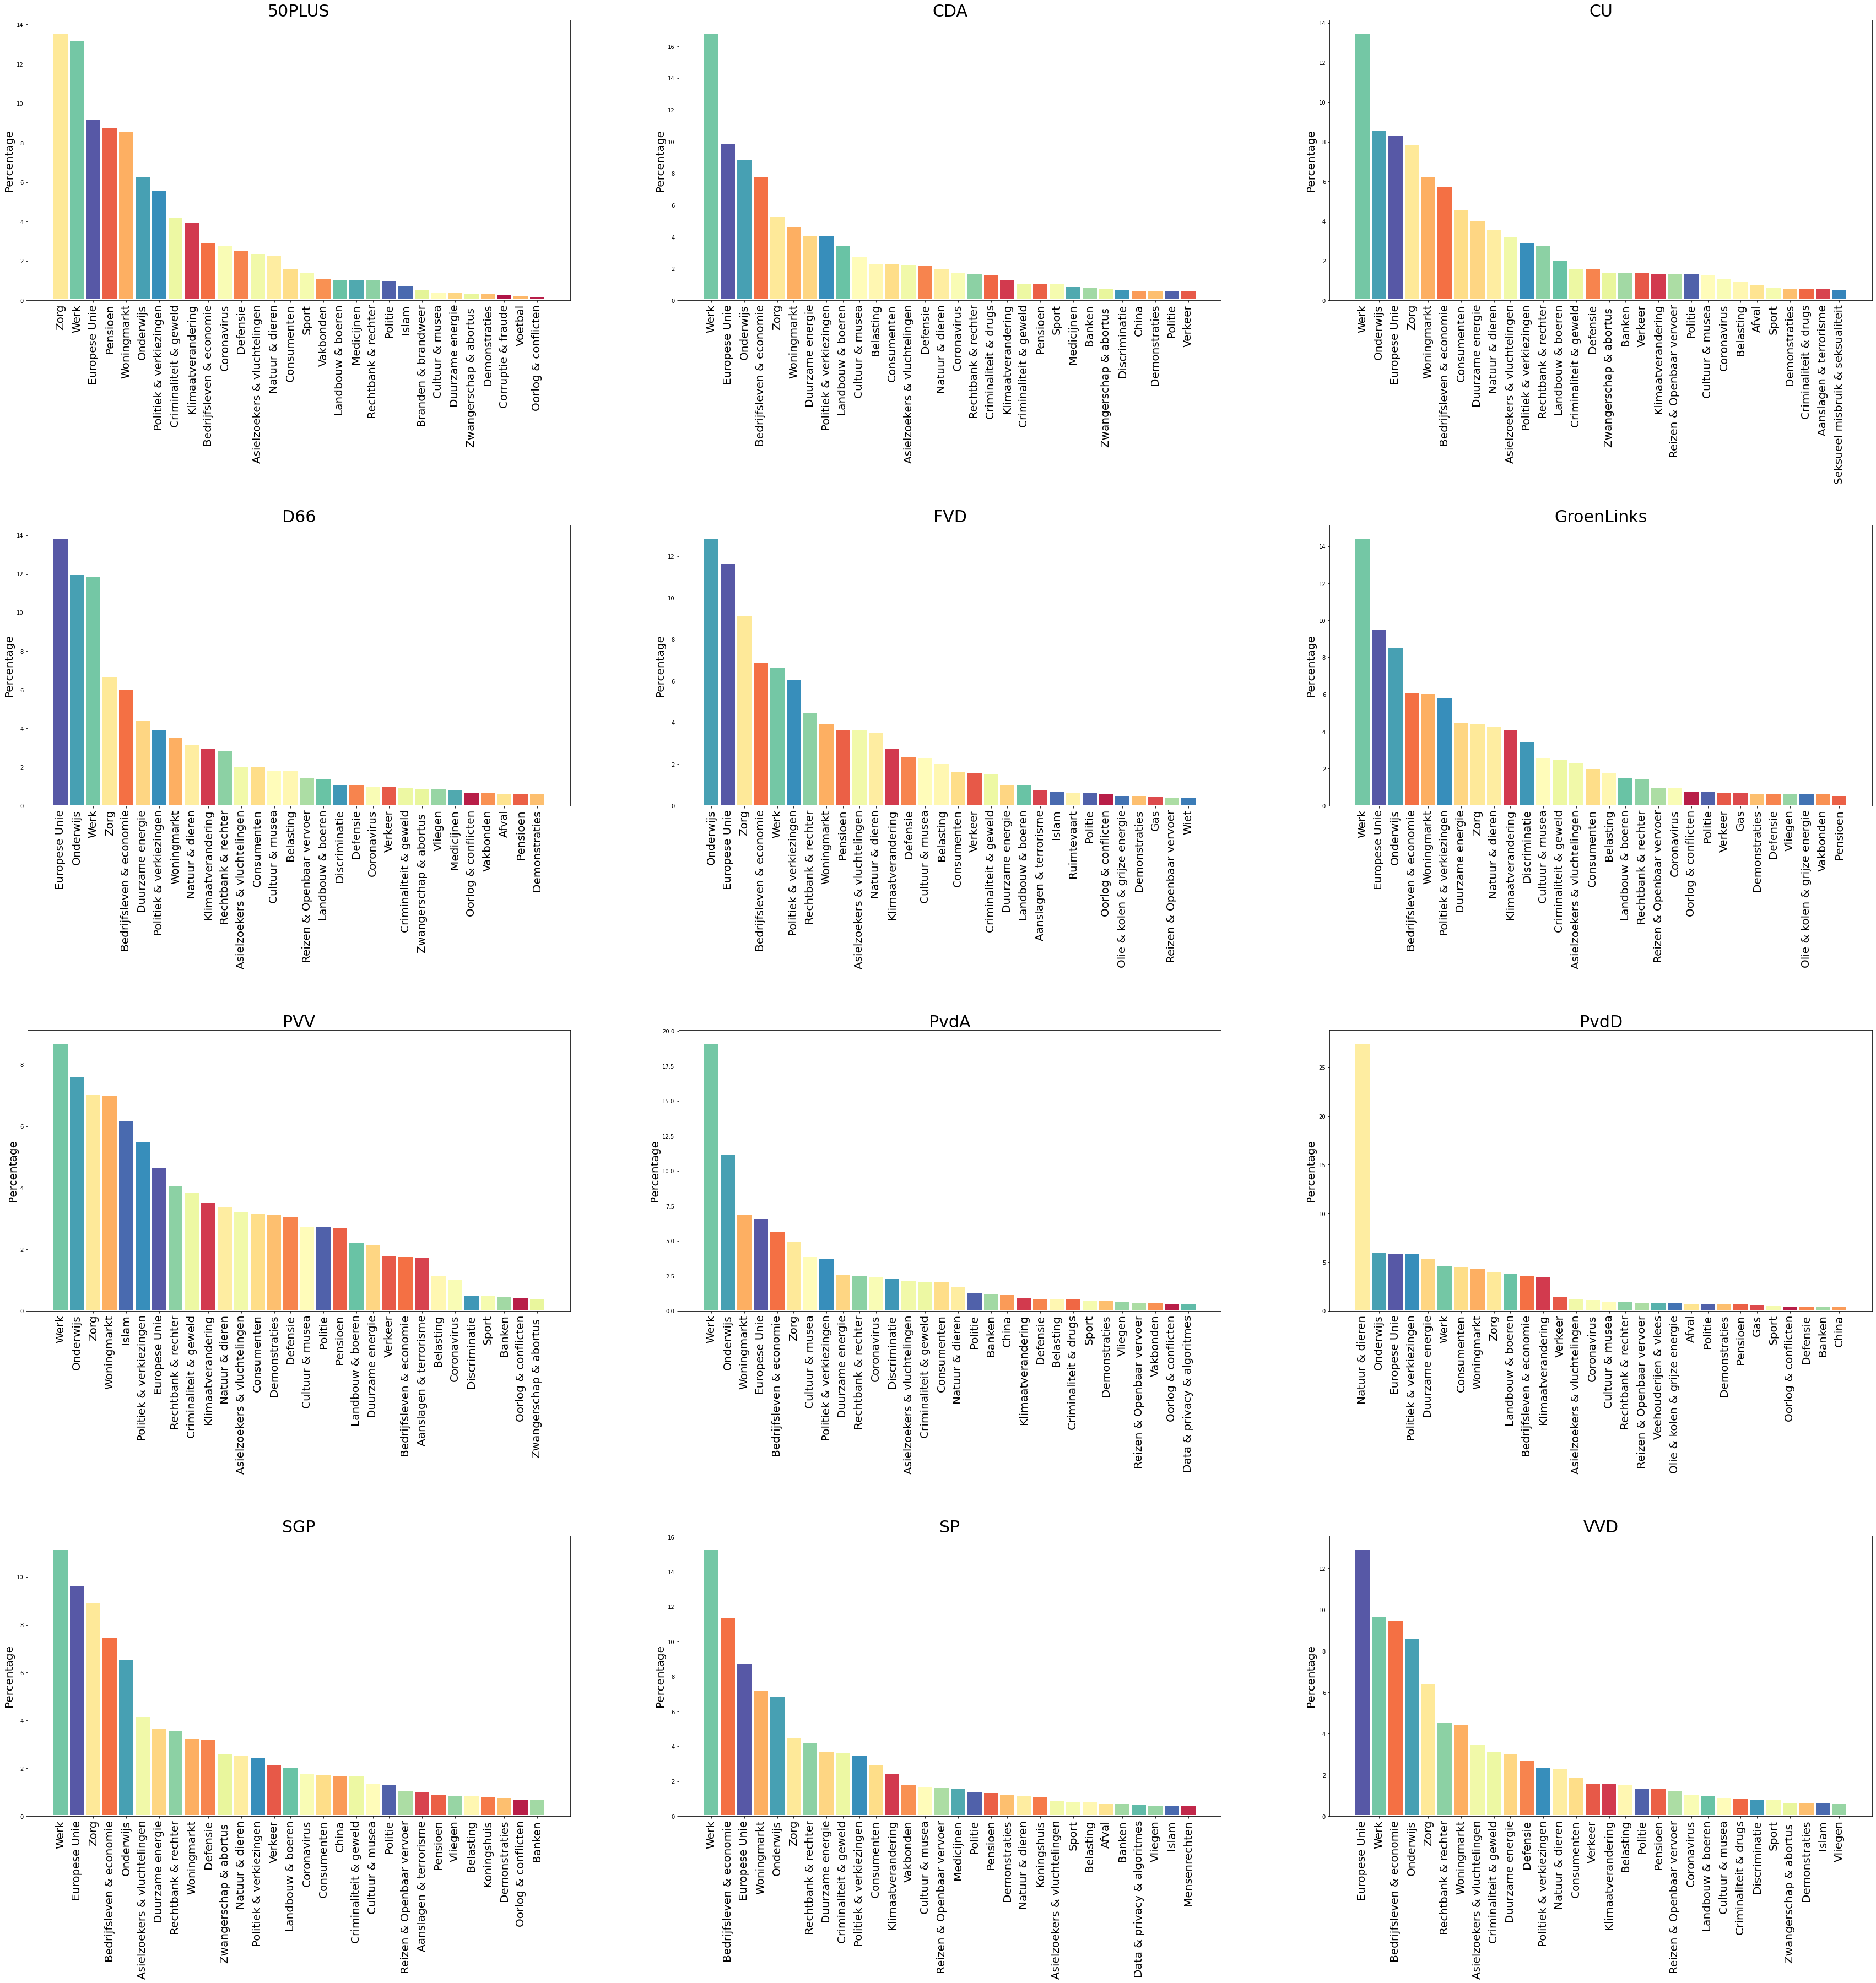

In [13]:
fig = plt.figure(figsize = (60,60))
fig.subplots_adjust(hspace=0.8, wspace=0.2)

ls = topics_over_doc.drop(columns = ['partij','step']).columns.tolist()
ls = random.sample(ls,len(ls))

colors = sns.color_palette('Spectral', int(len(ls)) ) 
color = { k:c for k,c in zip(ls, colors ) }

bar_width = 0.5
for i,(partij, data_partij) in enumerate(topics_over_doc.groupby('partij')):
    ax = fig.add_subplot(4,3,1+i)
    
    probs = data_partij.set_index('step').drop(columns = ['partij'])
    
    perc = probs[probs > 0.1].fillna(0).sum(axis=0)
    perc = (perc / perc.sum() *100).sort_values(ascending=False)
    perc.to_csv('Results/{}_verdeling.csv'.format(partij))
    
    

    xticks = []
    xticklabels = []
    for ii,(name, val) in enumerate(perc.iloc[0:30].items() ):
        x_pos = ii
        ax.bar([x_pos*bar_width +1], [val], width=bar_width, bottom = 0, color= color[name],linewidth=4, edgecolor='w')
        xticks.append(x_pos*bar_width +1)
        xticklabels.append(name.replace('_',' & '))

    ax.set_title(partij,fontsize=30)
    ax.set_xticks(xticks)
    _ = ax.set_xticklabels(xticklabels, rotation= 90, fontsize=20)
    ax.set_ylabel('Percentage',fontsize=20)


In [14]:
df = []
for file in os.listdir('Results/'):
    if( '_verdeling' in file):
        df_ = pd.read_csv('Results/'+file).set_index('Unnamed: 0')
        df_.columns = [file.strip('_verdeling.csv')]
        df.append(df_.iloc[:,0])
        
        
verdeling = pd.DataFrame(df)

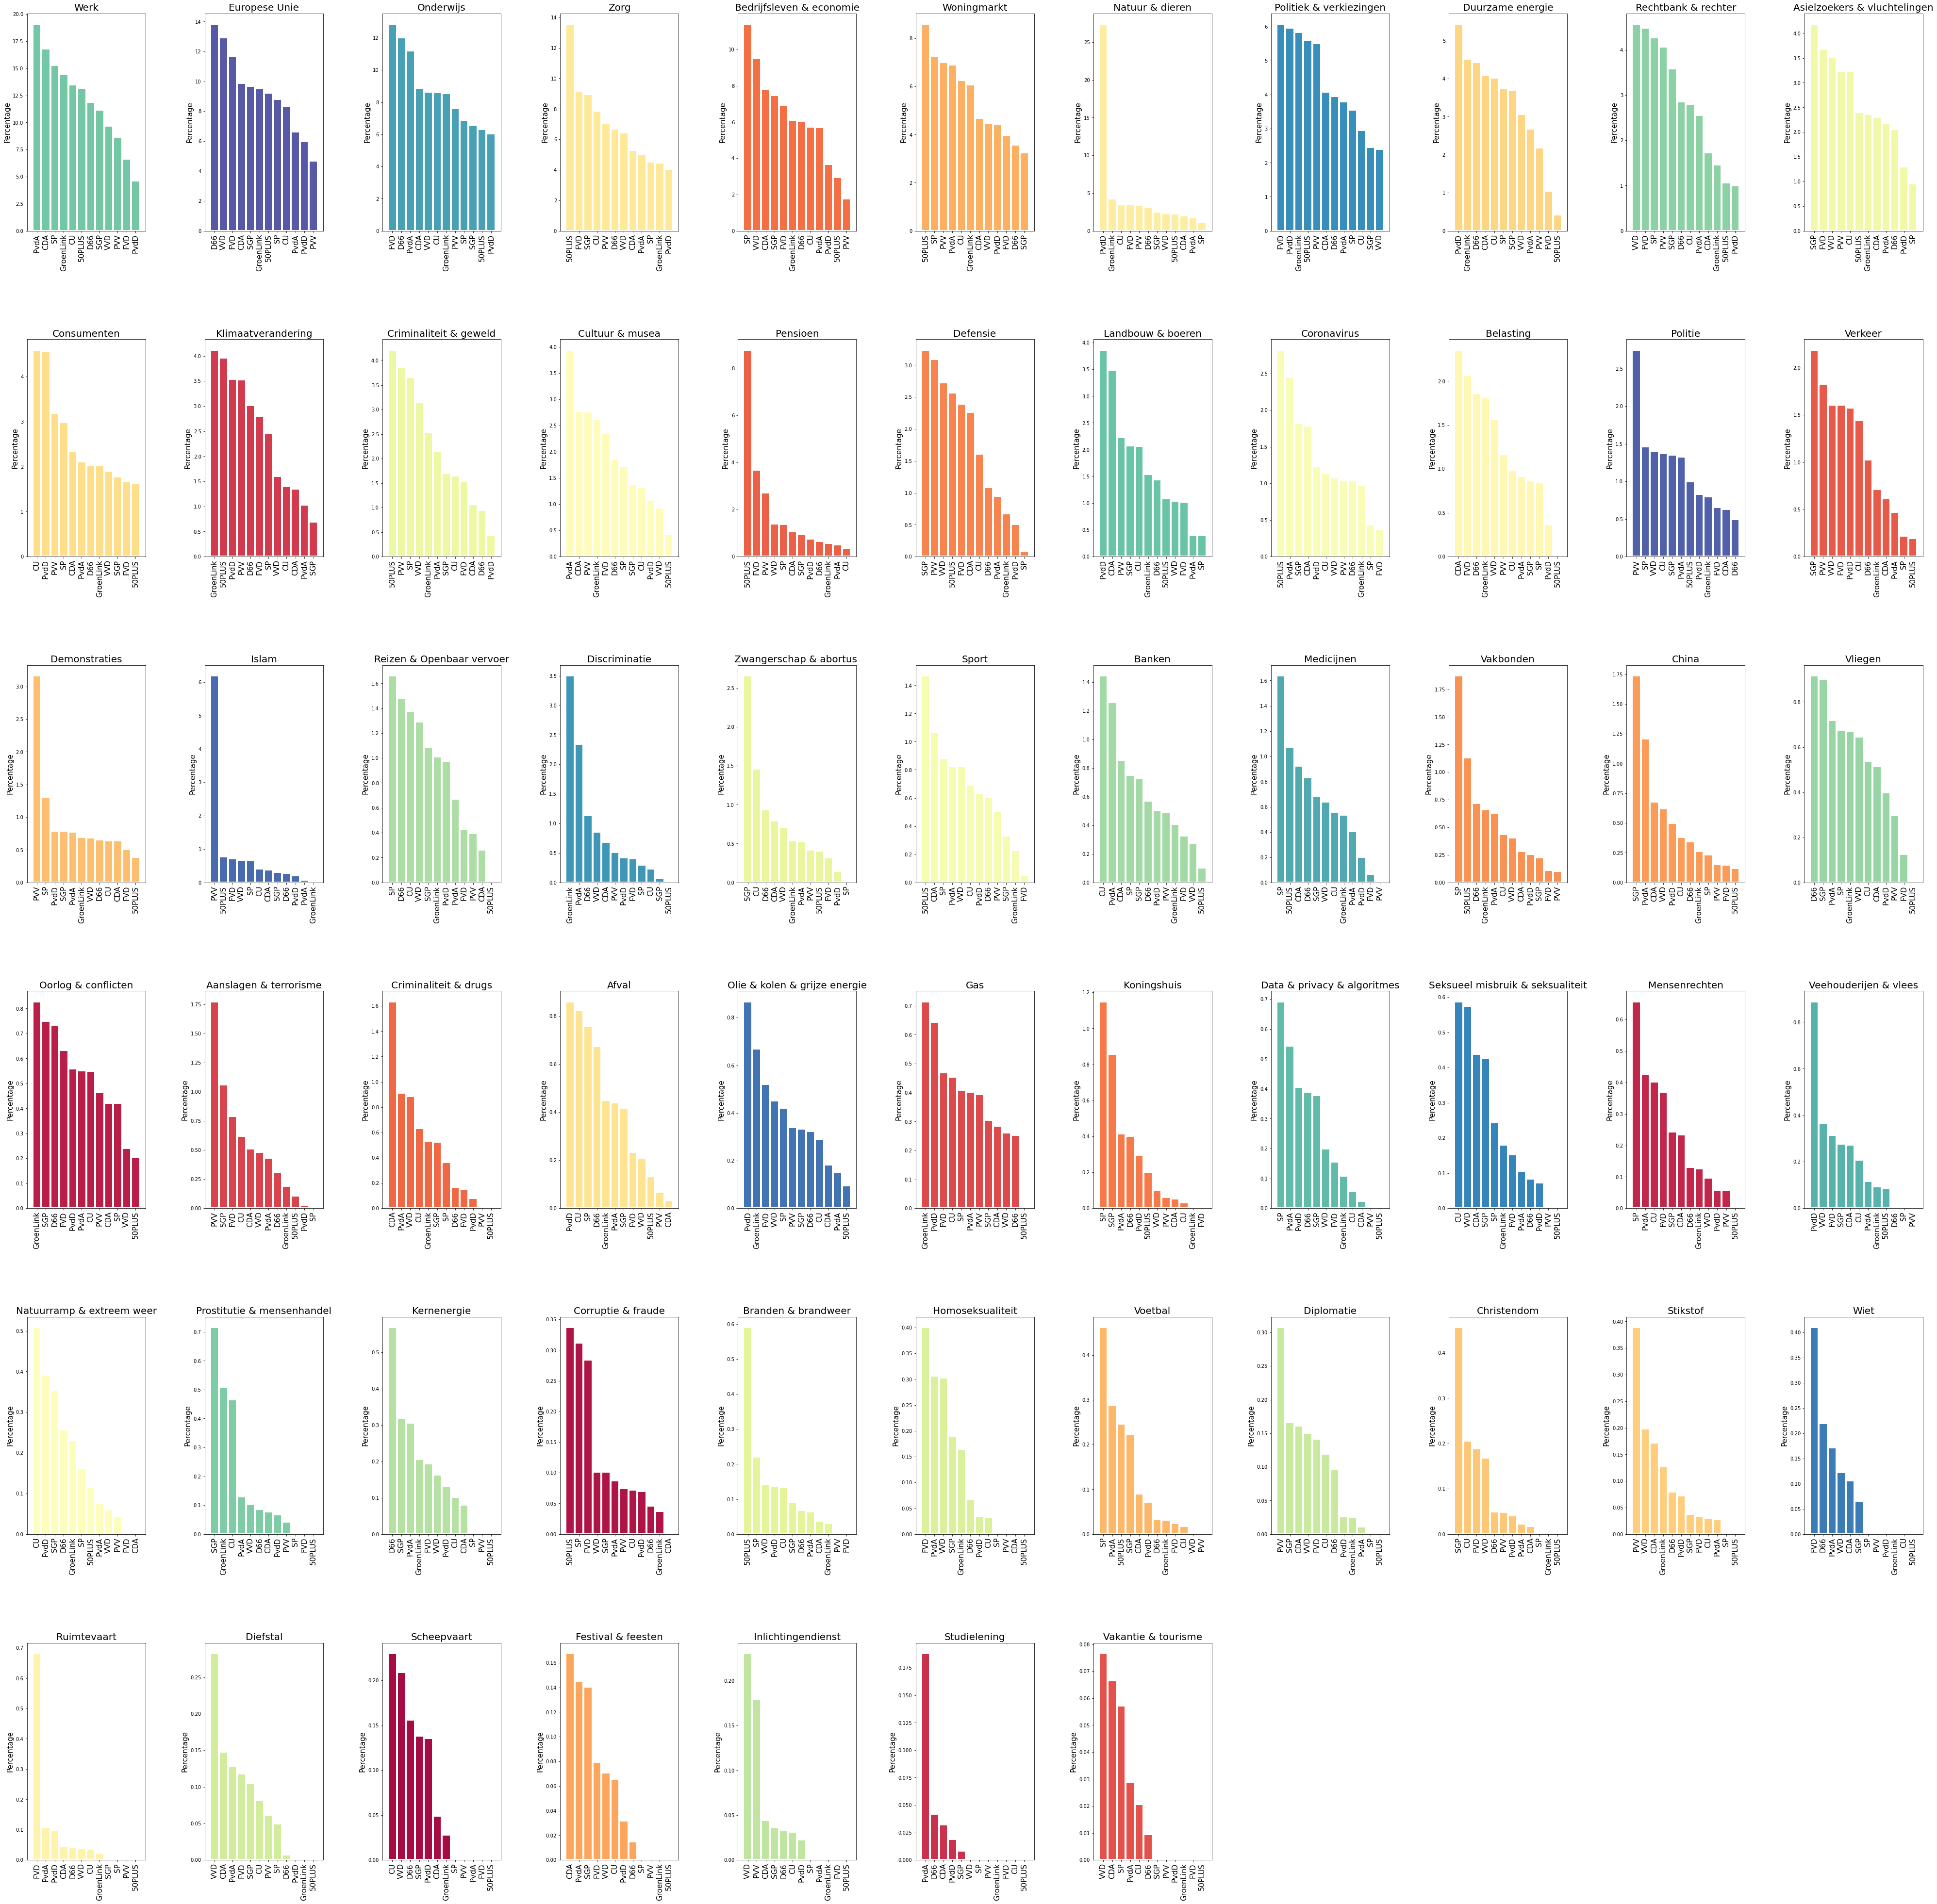

In [15]:

fig = plt.figure(figsize = (70,70))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

k = 0
for topic,x in verdeling[verdeling.sum().sort_values(ascending=False).index].items():
    x = x.fillna(0).sort_values(ascending= False)
    k+=1
    ax = fig.add_subplot(6,11,k)

    xticks = []
    xticklabels = []
    for i,(name, val) in enumerate(x.items() ):
        x_pos = i

        ax.bar([x_pos*bar_width +1], [val], width=bar_width, bottom = 0, color= color[topic],linewidth=4, edgecolor='w')

        xticks.append(x_pos*bar_width +1)
        xticklabels.append(name.replace('_',' & '))


    ax.set_xticks(xticks)
    _ = ax.set_xticklabels(xticklabels, rotation= 90, fontsize=15)
    ax.set_ylabel('Percentage',fontsize=15)
    ax.set_title(topic,fontsize=20)
        